# CellPredX Tutorial: End-to-End Workflow on the CITE-ASAP Dataset

This tutorial provides a step-by-step walkthrough of the **full CellPredX workflow** on the CITE-ASAP dataset, including:

1. Data preparation and preprocessing  
2. Building and configuring the CellPredX model  
3. Model training and evaluation  
4. Interpreting the main matrices and outputs  

It is intended as a practical, self-contained guide for new users.

---

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sps
from os.path import join

# Make sure we can import project modules
sys.path.append('/data/yan_code/scDWL/')   # adapt this path to your local clone

from core import BuildCellpredX   # main CellPredX class

# --------------------------
# 1. Global settings
# --------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose which GPU to use
np.random.seed(1234)
sc.settings.verbosity = 3
sc.logging.print_header()

# --------------------------
# 2. Load multi-omic data
# --------------------------
exp_id = 'CITE-ASAP-1201'  # dataset_name + timestamp (for output)
data_root = '/data/yan_code/scNCL-release/data/scNCL_data/'

# scRNA-seq (reference)
adata_rna = sc.read_h5ad(join(data_root, 'CITE-ASAP/adata_rna_cache.h5ad'))

# scATAC-seq (query)
adata_atac = sc.read_h5ad(join(data_root, 'CITE-ASAP/adata_atac_cache.h5ad'))

# Optional: inspect metadata
meta_rna = adata_rna.obs
meta_atac = adata_atac.obs
meta = pd.concat([meta_rna, meta_atac], axis=0)

# Proteomics / ADT data, already log-normalized
adata_cite_adt = sc.AnnData(
    sps.load_npz(join(data_root, 'CITE-ASAP/citeseq_control_adt.npz')),
    obs=adata_rna.obs,
)
adata_asap_adt = sc.AnnData(
    sps.load_npz(join(data_root, 'CITE-ASAP/asapseq_control_adt.npz')),
    obs=adata_atac.obs,
)

# Raw ATAC embedding (used to construct k-NN graph in ATAC space)
atac_raw_emb = adata_asap_adt.X.A   # dense matrix: [n_ATAC_cells, n_ADT_features]


/home/liuyan/anaconda3/envs/scprotein/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.9.2 umap==0.5.7 numpy==1.22.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.6 pynndescent==0.5.13


3.1 Preprocessing configuration

In [2]:
# Preprocessing parameters
ppd = {
    'binz': True,                  # whether to binarize counts before preprocessing
    'hvg_num': adata_atac.shape[1],# number of highly variable features (here: use all)
    'lognorm': False,              # whether to log-normalize gene features
    'scale_per_batch': False,      # whether to scale each batch separately
    'batch_label': 'domain',       # column in .obs indicating batch/modality
    'type_label':  'cell_type',    # column in .obs indicating cell type
    'knn': 10,                     # k in k-NN for ATAC neighborhood graph
    'knn_by_tissue': False,        # set to True to build k-NN within each tissue
}

3.2 Instantiate the CellPredX model

In [3]:
# Output directory
myoutput_dir = join(f'/data/yan_code/scDWL/outputs/{exp_id}')
os.makedirs(myoutput_dir, exist_ok=True)

# Build CellPredX model
model = BuildCellpredX(
    n_latent=48,      # latent dimension of the shared embedding
    bn=False,         # batch normalization in encoder
    dr=1.2,           # dropout rate (or related regularization parameter)
    cont_w=0,         # weight for contrastive loss (set >0 to enable)
    cont_tau=0.8,     # temperature for contrastive loss
    mycenter_w=0.01,  # weight for Sparse Center Loss
    center_cutoff=0,  # step at which to start center loss
)

3.3 Data preprocessing and feature construction

During peak_preprocess, the following operations are performed:
	•	The RNA and ATAC matrices are log-transformed (X = log1p(X)).
	•	self.data_A (reference) and self.data_B (query) are constructed as sparse matrices, optionally concatenated with ADT features:
	
	•	data_A: n_RNA_cells × n_features_total
	•	data_B: n_ATAC_cells × n_features_total
	•	self.emb_B stores the raw ATAC embedding (atac_raw_emb), used to build a k-NN graph in ATAC space.
	•	self.meta_A and self.meta_B store metadata for reference and query cells.
	•	relabel converts string cell-type labels to integer IDs:
	•	trainlabel2id: {cell_type_name → class_id}
	•	id2trainlabel: {class_id → cell_type_name}
	•	y_id_A: integer labels for reference cells
	•	shuffle_data shuffles reference and query cells for training.
	•	get_nns computes a k-NN index (self.knn_ind) in ATAC space based on the shuffled ATAC embeddings.

The function returns:
	•	atac_number_label: integer labels for query ATAC cells mapped to the reference label space
	•	label_dict: the mapping from original cell-type names to integer IDs

In [4]:
# Preprocess RNA & ATAC (and optionally ADT) data
atac_number_label, label_dict = model.peak_preprocess(
    adata_inputs=[adata_rna, adata_atac],   # [reference, query] AnnData
    atac_raw_emb=atac_raw_emb,             # raw ATAC embedding (for k-NN)
    pp_dict=ppd,
    adata_adt_inputs=[adata_cite_adt, adata_asap_adt],  # optional ADT features
)

Concating adt features...
==========************************************================
knn correct ratio = 0.8936
===========**************************************===============


4. Model Training

4.1 What happens during training?

On each training step, train_step does the following:

	1.	Batch sampling
	•	Sample a mini-batch of reference cells (x_A) and query cells (x_B).
	2.	Forward pass
	•	Pass x_A and x_B through the shared encoder to obtain latent embeddings f_A and f_B.
	•	Pass embeddings through the classification head to obtain logits p_A and p_B.
	3.	Loss components
	•	Supervised cross-entropy loss on reference data:
loss_cls = CrossEntropy(p_A, y_A)
	•	Projection regularization / NNDR-style loss (center, decorrelation, variance) encouraging a structured latent space.
	•	Contrastive loss (optional): encourages cells with similar ATAC embeddings to be close in latent space.
	•	Alignment loss: aligns query and reference embeddings using cosine similarity with negative samples.
	•	Sparse Center Loss: encourages cluster structure in latent space using both true labels (RNA) and confident pseudo-labels (ATAC).
	•	L1 regularization on encoder and head.
	4.	Parameter updates
	•	Backpropagate the combined loss and update encoder and head with SGD/Adam.
	•	Step the learning rate schedulers.

Intermediate evaluation reports:
	•	Training losses (classification, regularization, contrastive, alignment, center loss).
	•	ATAC cell-type annotation performance (accuracy, macro-F1, open-set metrics) if ground-truth labels are available.

In [5]:
if True:
    model.train(
        opt='sgd',             # or 'adam'
        batch_size=512,
        training_steps=100,
        lr=0.01,
        lr2=None,
        weight_decay=5e-4,
        log_step=50,
        eval_atac=True,        # evaluate ATAC annotation during training
        eval_top_k=2,          # top-k accuracy for ATAC pseudo-labels
        eval_open=True,        # open-set evaluation (novel cell types)
        output_dir=myoutput_dir,
    )
else:
    # Load a pre-trained checkpoint instead of training
    ckpt_path = join(myoutput_dir, 'ckpt_cite.pth')
    model.load_ckpt(ckpt_path)

step 0, loss_cls=1.896, loss_l1_reg=0.142, center=(0.017, 0.033), corr=(0.000, 0.001), var=(0.970, 0.400), loss_cont=0.000, loss_align=0.000, loss_mycenter=0.000
close_acc= 0.2548
AUROC= 0.6359
AUPR= 0.1793
OSCR= 0.1701
step 50, loss_cls=0.123, loss_l1_reg=0.139, center=(0.075, 0.067), corr=(0.015, 0.011), var=(0.139, 0.150), loss_cont=0.000, loss_align=0.000, loss_mycenter=0.131
close_acc= 0.8910
AUROC= 0.7646
AUPR= 0.2395
OSCR= 0.7135
Ending time:  Sat Nov 15 14:14:26 2025
Training takes 78.77 seconds


5. Evaluation and Interpretation of Outputs

5.1 Get latent embeddings and prediction probabilities

This returns four matrices:

	•	feat_A: Latent embeddings for reference (RNA) cells
	•	Shape: [n_RNA_cells, n_latent]
	•	feat_B: Latent embeddings for query (ATAC) cells
	•	Shape: [n_ATAC_cells, n_latent]
	•	head_A: Class probabilities for reference cells (after softmax)
	•	Shape: [n_RNA_cells, n_classes]
	•	head_B: Class probabilities for query cells
	•	Shape: [n_ATAC_cells, n_classes]

In [ ]:
model.eval(inplace=True)
# then access:
#   model.feat_A, model.feat_B, model.head_A, model.head_B


5.2 Cell-type annotation of scATAC-seq data

	•	This function takes the argmax of head_B (predicted class ID for each ATAC cell)
	•	Then maps class IDs back to cell-type names using id2trainlabel.
	•	If label_prop=True, a k-NN label propagation step in latent space is performed to further smooth predictions.

In [9]:
atac_pred_labels = model.annotate(label_prop=False)
atac_pred_labels

array(['Effector CD8+ T', 'Monocytes', 'Naive CD8+ T', ...,
       'Naive CD4+ T', 'Monocytes', 'Effector CD4+ T'], dtype='<U15')

5.3 Interpreting the main matrices

Here is a summary of the key matrices and what they mean:

Variable
Shape
Description

data_A
[n_RNA_cells, n_features]
Preprocessed reference features (RNA +/- ADT), used as model input.

data_B
[n_ATAC_cells, n_features]
Preprocessed query features (ATAC +/- ADT), used as model input.

emb_B
[n_ATAC_cells, n_raw_emb]
Raw ATAC embeddings (e.g., ADT-based), used to build the ATAC k-NN graph.

feat_A
[n_RNA_cells, n_latent]
Learned latent representation of reference cells in the shared embedding space.

feat_B
[n_ATAC_cells, n_latent]
Learned latent representation of query cells in the same embedding space.

head_A
[n_RNA_cells, n_classes]
Class probabilities for reference cells (softmax output of classifier).

head_B
[n_ATAC_cells, n_classes]
Class probabilities for query cells.

y_id_A
[n_RNA_cells]
Integer labels for reference cell types.

y_id_B
[n_ATAC_cells]
Integer labels for ATAC cell types (if available).

trainlabel2id
dict
Maps cell-type names → integer class IDs.


id2trainlabel
dict
Maps integer class IDs → cell-type names.

knn_ind
[n_ATAC_cells, k]
Indices of ATAC neighbors used for contrastive / neighborhood-based losses.


6. Optional: Visualization Example

A simple UMAP visualization of the learned embeddings:

This allows users to directly inspect:
	•	Whether reference and query cells are well aligned in the latent space,
	•	Whether cells cluster according to biologically meaningful cell types rather than technical batches.

In [11]:
adata_atac

AnnData object with n_obs × n_vars = 4502 × 17441
    obs: 'cell_type', 'data_type'

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/home/liuyan/anaconda3/envs/scprotein/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/liuyan/anaconda3/envs/scprotein/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


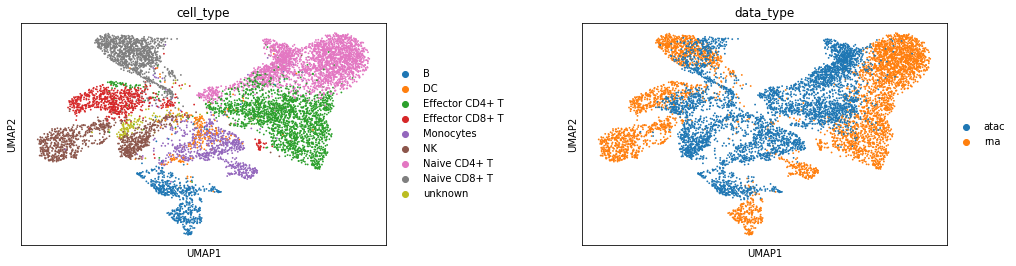

In [12]:
import scanpy as sc
import anndata as ad
import numpy as np

# Combine RNA + ATAC embeddings
combined_emb = np.vstack([model.feat_A, model.feat_B])
combined_meta = pd.concat([model.meta_A, model.meta_B], axis=0)

adata_emb = ad.AnnData(X=combined_emb)
adata_emb.obs = combined_meta.copy()

sc.pp.neighbors(adata_emb, use_rep='X')
sc.tl.umap(adata_emb)

sc.pl.umap(
    adata_emb,
    color=['cell_type', 'data_type'],
    wspace=0.4
)